# Homework 6  $-$ Play with Machine Learning

## Definition

This homework is extremely simple.
<br>
1. Run this Notebook.
2. Create two new perceptrons in the code section. Change parameters and see if you can produce a better estimate. You should create the perceptrons, compute the errors and plot the scatter plot. This is literally just cut, paste and modify code.

## Moneyball Formal Definition Continued


### Formal Definition

- A vector of metrics $\vec{x} = (x_1, x_2, ..., x_n)$ summarizes a team's performance capabilities, e.g. batting average, HRs, etc.


- A similar vector $\vec{p} = (p_1, p_2, ..., p_n)$ summarizes the performance of an a player with respect to the metrics. $T.$


- Let $i$ be the subscript notation for the i-th metric. If $f_i$ is some aggregation function, e.g. sum, average, then

\begin{equation}
x_i = f_i(p_i), \forall p \in T.
\end{equation}


- $S(p)$ can denote player $p$'s salary. This yields two constraints
    - C1: $ \#(T) \leq 25$ (approximating the maximum number of allowed players per team)
    - C2: $\sum_{p \in T}{S(p)} \leq B(T),$ team $T$ budget.
    
    
- If
    - $W(\vec{x})$ is the number of wins per season as a function of $\vec{x} \in X.$
    - $P(\vec{x}) \rightarrow [0,1]$ is the probability of winning the World Series for $\vec{x} \in X.$
    
    
- We want to pick the team of players $T$ such that we 
    - $Max(W(\vec{x}))$ or $Max(P(\vec{x}))$
    - With minimal $\sum{S(p)}$
    - Subject to C1 and C2.
    
    
- This boils down to two tasks:
    1. _Learning_ the relationship between $\vec{x}$ and wins (or winning world series).
    1. Finding the price-optimal set of players. 
    
    
- We are trying to build an artificial intelligence engine that replaces general managers for picking players.


- The first step is to figure out, or __learn__, $W(\vec{x}).$

### Estimate Wins from Performance

#### Recreate the Training Data from Last Lecture

<u>Load the team data.</u>

In [2]:
import pandas as pd

team_df = pd.read_csv("../Data/teaminfo.csv")
team_df.tail(10)

,year,teamid,rank,games,wins,loses,WSWin,runs,at_basts,hits,...,walks,strikeouts,stolen_bases,caught_stealing,sacrifice_flies,runs_against,earned_runs,earned_run_average,errors,fielding_percentage
908,2016,PHI,4,162,71,91,N,610,5434,1305,...,424,1376,96,45,30.0,796,739,4.63,97,0.984
909,2016,PIT,3,162,78,83,N,729,5542,1426,...,561,1334,110,45,36.0,758,679,4.21,111,0.982
910,2016,SDN,5,162,68,94,N,686,5419,1275,...,449,1500,125,45,36.0,770,708,4.43,109,0.982
911,2016,SEA,2,162,86,76,N,768,5583,1446,...,506,1288,56,28,41.0,707,647,4.00,89,0.985
912,2016,SFN,2,162,87,75,N,715,5565,1437,...,572,1107,79,36,46.0,631,593,3.65,72,0.988
913,2016,SLN,2,162,86,76,N,779,5548,1415,...,526,1318,35,26,41.0,712,656,4.08,107,0.983
914,2016,TBA,5,162,68,94,N,672,5481,1333,...,449,1482,60,37,28.0,713,665,4.20,94,0.984
915,2016,TEX,1,162,95,67,N,765,5525,1446,...,436,1220,99,36,40.0,757,700,4.37,97,0.984
916,2016,TOR,2,162,89,73,N,759,5479,1358,...,632,1362,54,24,40.0,666,613,3.78,88,0.986
917,2016,WAS,1,162,95,67,N,763,5490,1403,...,536,1252,121,39,63.0,612,570,3.51,73,0.988


- Use _projection_ to get the columns we decided to use.

In [3]:
team_df.columns

Index(['year', 'teamid', 'rank', 'games', 'wins', 'loses', 'WSWin', 'runs',
       'at_basts', 'hits', 'doubles', 'triples', 'home_runs', 'walks',
       'strikeouts', 'stolen_bases', 'caught_stealing', 'sacrifice_flies',
       'runs_against', 'earned_runs', 'earned_run_average', 'errors',
       'fielding_percentage'],
      dtype='object')

In [4]:
training_data_df = team_df[['wins', 'at_basts', 'hits', 'doubles', 'triples', 'home_runs', \
                            'walks', 'earned_run_average', 'fielding_percentage']].copy()
training_data_df.tail(10)

,wins,at_basts,hits,doubles,triples,home_runs,walks,earned_run_average,fielding_percentage
908,71,5434,1305,231,35,161,424,4.63,0.984
909,78,5542,1426,277,32,153,561,4.21,0.982
910,68,5419,1275,257,26,177,449,4.43,0.982
911,86,5583,1446,251,17,223,506,4.00,0.985
912,87,5565,1437,280,54,130,572,3.65,0.988
913,86,5548,1415,299,32,225,526,4.08,0.983
914,68,5481,1333,288,32,216,449,4.20,0.984
915,95,5525,1446,257,23,215,436,4.37,0.984
916,89,5479,1358,276,18,221,632,3.78,0.986
917,95,5490,1403,268,29,203,536,3.51,0.988


- Compute the derived performance metrics.

In [5]:
obp = \
    (training_data_df['hits'] + training_data_df['walks']) / (training_data_df['at_basts'] + training_data_df['walks'])
training_data_df['obp'] =   obp

In [6]:
training_data_df['singles'] = \
    training_data_df['hits'] - training_data_df['doubles'] - training_data_df['triples'] - \
    training_data_df['home_runs']

In [7]:
training_data_df['slg'] = \
    ( training_data_df['singles'] + 2*training_data_df['doubles'] + \
        3*training_data_df['triples'] + 4*training_data_df['home_runs'] ) / training_data_df['at_basts']

In [8]:
training_data_df.tail(10)

,wins,at_basts,hits,doubles,triples,home_runs,walks,earned_run_average,fielding_percentage,obp,singles,slg
908,71,5434,1305,231,35,161,424,4.63,0.984,0.295152,878,0.384431
909,78,5542,1426,277,32,153,561,4.21,0.982,0.325578,964,0.401660
910,68,5419,1275,257,26,177,449,4.43,0.982,0.293797,815,0.390293
911,86,5583,1446,251,17,223,506,4.00,0.985,0.320578,955,0.429876
912,87,5565,1437,280,54,130,572,3.65,0.988,0.327359,973,0.398023
913,86,5548,1415,299,32,225,526,4.08,0.983,0.319559,859,0.442141
914,68,5481,1333,288,32,216,449,4.20,0.984,0.300506,797,0.425652
915,95,5525,1446,257,23,215,436,4.37,0.984,0.315719,951,0.433303
916,89,5479,1358,276,18,221,632,3.78,0.986,0.325642,843,0.425808
917,95,5490,1403,268,29,203,536,3.51,0.988,0.321772,903,0.425865


In [9]:
final_t = training_data_df.drop(['at_basts', 'hits', 'doubles', 'triples', 'home_runs', 'walks', 'singles'], axis=1)
final_t.tail(10)

,wins,earned_run_average,fielding_percentage,obp,slg
908,71,4.63,0.984,0.295152,0.384431
909,78,4.21,0.982,0.325578,0.401660
910,68,4.43,0.982,0.293797,0.390293
911,86,4.00,0.985,0.320578,0.429876
912,87,3.65,0.988,0.327359,0.398023
913,86,4.08,0.983,0.319559,0.442141
914,68,4.20,0.984,0.300506,0.425652
915,95,4.37,0.984,0.315719,0.433303
916,89,3.78,0.986,0.325642,0.425808
917,95,3.51,0.988,0.321772,0.425865


#### Train MLP

- Training requires __X__ and _y._


In [10]:
X = final_t[['earned_run_average', 'fielding_percentage', \
                       'obp', 'slg']]
y = final_t['wins']

In [11]:
X.tail(10)

,earned_run_average,fielding_percentage,obp,slg
908,4.63,0.984,0.295152,0.384431
909,4.21,0.982,0.325578,0.401660
910,4.43,0.982,0.293797,0.390293
911,4.00,0.985,0.320578,0.429876
912,3.65,0.988,0.327359,0.398023
913,4.08,0.983,0.319559,0.442141
914,4.20,0.984,0.300506,0.425652
915,4.37,0.984,0.315719,0.433303
916,3.78,0.986,0.325642,0.425808
917,3.51,0.988,0.321772,0.425865


In [12]:
y.tail(10)

908    71
909    78
910    68
911    86
912    87
913    86
914    68
915    95
916    89
917    95
Name: wins, dtype: int64

- Produce training and testing sets. The framework comes with a simple utility: ```train_test_split.```

In [13]:
# Import the train test split.
from sklearn.model_selection import train_test_split

# Produce the X_train and X_test data and the y_train and y_test data.
X_train, X_test, y_train, y_test = train_test_split(X, y)

- "The neural network in Python may have difficulty converging before the maximum number of iterations allowed if the data is not normalized. Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data." (https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/) 

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

- Finally, we will build an MLP!

In [15]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(4,4,4),max_iter=50000)

- What is ```mlp?```

In [16]:
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 4, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=50000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

- ```mlp``` is a variable referencing an object from class ```MLPClassifier.```
    - ```MLPClassifier``` has 21 configuration options that you can set in a constructor.
    - I chose the defaults except for ```hidden_layer_sizes``` and ```max_iterations.```
    
    
- This demonstrates a couple of the concepts we have covered:
    - Default parameters simplifying using functions or classes.
    - The concept of a single module/package providing multiple objects with different configuration choices to govern the modules behavior for functions. I can and typically would make several MLPs with different choices, but all execute the same code.
    
    
- Now, let's TRAIN and LEARN.

In [17]:
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 4, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=50000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

- We trained the MLP. Now have it make some predictions and compare to what actually happened.


In [18]:
import matplotlib.pyplot as plt 

predictions = mlp.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])

- That is rather odd looking. How accurate were we?

In [19]:
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg=errs['e'].mean()
std=errs['e'].std()
print("Avg error = ", avg)
print("Std Deviation = ", std)

Avg error =  4.630434782608695
Std Deviation =  4.31387876840312


- On average, our prediction was off by 4 wins.

In [20]:
rel_errs = errs['e']/cmp['w']
re = rel_errs.mean()
re

0.06356336647534108

- Or 6%.

In [21]:
tmp = X_test[0:2]
print(X_test[0:2])
print(predictions[0:2])
X_test2 = [[5.0, 1.0, 0.0, 0.2], [1.0, 1.0, 0.7, 1.2]]
X_test2  = scaler.transform(X_test2)
print(X_test2)
pred2 = mlp.predict(X_test2)
pred2

[[-0.38654623  1.30993817  0.45530632  0.24301117]
 [ 1.23560582 -0.33225837 -0.61626664  0.04447612]]
[91 67]
[[  1.39603844   5.90808849 -21.57543741  -7.16269037]
 [ -5.73430026   5.90808849  24.70431803  26.9008131 ]]


array([59, 97], dtype=int64)

- Let's try a different configuration.

In [22]:
mlp2 = MLPClassifier(hidden_layer_sizes=(8,8,8),max_iter=50000)

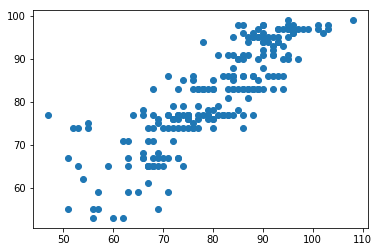

In [23]:
mlp2.fit(X_train,y_train)
predictions = mlp2.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])

In [24]:
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg3=errs['e'].mean()
print("Avg error = ", avg3)
print("Std Deviation = ", std)

Avg error =  4.978260869565218
Std Deviation =  4.31387876840312


- One more with feeling!

- Now I mean it.

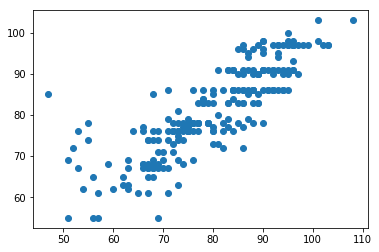

In [25]:
mlp3 = MLPClassifier(hidden_layer_sizes=(12,12,12,12,12),max_iter=50000)
mlp3.fit(X_train,y_train)
predictions = mlp3.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])

In [26]:
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg3=errs['e'].mean()
avg3

4.7043478260869565

__Different MLP__

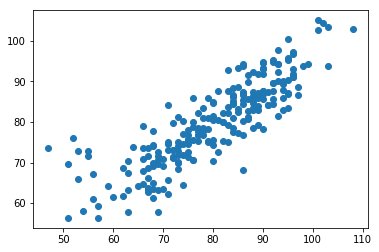

In [27]:
from sklearn.neural_network import MLPRegressor
mlp4 = MLPRegressor(hidden_layer_sizes=(24,24,24,24,24, 24,24,24),max_iter=100000)
mlp4.fit(X_train,y_train)
predictions = mlp4.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])

In [28]:
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg3=errs['e'].mean()
avg3

4.552584395174016

In [29]:
tmp = X_test[0:2]
print(X_test[0:2])
print(predictions[0:2])
X_test2 = [[5.0, 1.0, 0.0, 0.2], [1.0, 1.0, 0.7, 1.2]]
X_test2  = scaler.transform(X_test2)
print(X_test2)
pred2 = mlp4.predict(X_test2)
pred2

[[-0.38654623  1.30993817  0.45530632  0.24301117]
 [ 1.23560582 -0.33225837 -0.61626664  0.04447612]]
[84.36369125 64.50101809]
[[  1.39603844   5.90808849 -21.57543741  -7.16269037]
 [ -5.73430026   5.90808849  24.70431803  26.9008131 ]]


array([112.46448673, 494.80799393])

Avg error =  4.46519755160339
Std Deviation =  4.31387876840312


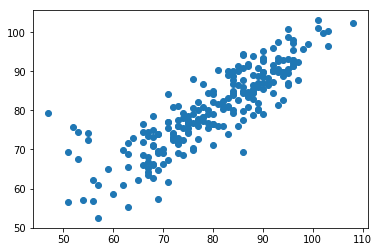

In [30]:
from sklearn.neural_network import MLPRegressor
mlp5 = MLPRegressor(hidden_layer_sizes=(64,64,64,64,64, 64,64,64,64,64),max_iter=100000)
mlp5.fit(X_train,y_train)
predictions = mlp5.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg3=errs['e'].mean()
print("Avg error = ", avg3)
print("Std Deviation = ", std)

Avg error =  4.60415243698168
Std Deviation =  4.06808022106334


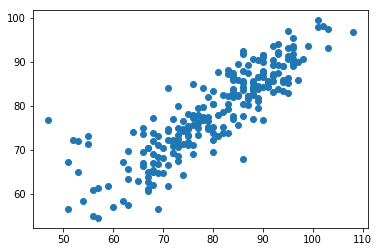

In [31]:
from sklearn.neural_network import MLPRegressor
mlp6 = MLPRegressor(hidden_layer_sizes=(256,256,256, \
                                        256,256,256,256,256,256,256,256,256,256, \
                                        256,256,256,256,256,256,256),max_iter=100000)
mlp6.fit(X_train,y_train)
predictions = mlp6.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg3=errs['e'].mean()
std=errs['e'].std()
print("Avg error = ", avg3)
print("Std Deviation = ", std)


## Your Code

### Perceptron 1

Avg error =  4.509710684918139
Std Deviation =  4.32961078478552


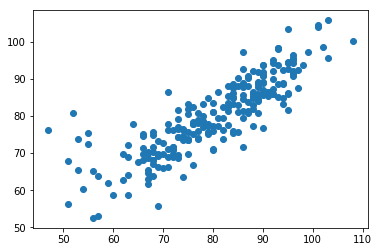

In [32]:
# I tried to have six hiden layers and each has six neural. 
# And I set the max_iter to be smaller say: 1000
from sklearn.neural_network import MLPRegressor
mlp6 = MLPRegressor(hidden_layer_sizes=(6,6,6,6,6,6),max_iter=1000)
mlp6.fit(X_train,y_train)
predictions = mlp6.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg3=errs['e'].mean()
std=errs['e'].std()
print("Avg error = ", avg3)
print("Std Deviation = ", std)


Clearly, my model have a better result than mlp, mlp2.Since the average error is smaller.

### Perceptron 2

Avg error =  4.329378190493948
Std Deviation =  4.1686243007191965


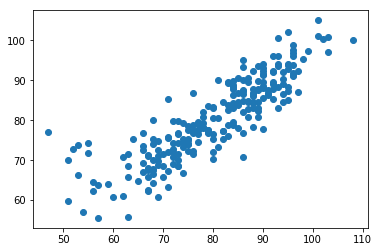

In [33]:
# samiliarly i set the hidden layer size to be 10 * 10
# And I set bigger max_iter to be 10000000000
from sklearn.neural_network import MLPRegressor
mlp6 = MLPRegressor(hidden_layer_sizes=(10,10,10,10,10,10,10,10,10,10),max_iter=10000000000)
mlp6.fit(X_train,y_train)
predictions = mlp6.predict(X_test)

cmp = pd.DataFrame()
cmp['w'] = y_test
cmp['pred_w'] = predictions

plt.scatter(cmp['w'],cmp['pred_w'])
errs = pd.DataFrame()
errs['e']=cmp['w']-cmp['pred_w']
errs['e']=errs['e'].abs()
avg3=errs['e'].mean()
std=errs['e'].std()
print("Avg error = ", avg3)
print("Std Deviation = ", std)

the result of this model is even better. But it is still a litte worse than mlp4.